In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline
import seaborn as sns
import platform
from matplotlib import font_manager , rc

if platform.system() == 'Darwin':
  rc('font' , family = 'AppleGothic')
elif platform.system() == 'Windows':
  path = 'C:/Windows/Fonts/malgun.ttf'
  font_name = font_manager.FontProperties(fname = path).get_name()
  rc('font' , family = font_name)
else:
  print('모름')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score , precision_score , recall_score , roc_auc_score , f1_score , confusion_matrix , roc_curve , precision_recall_curve

# 목표 : engine에 따라 차종을 분류하고 , engine을 제거 후 size로 대체 , 그 과정에서 NA값을 채울 때 다양한 모델들을 써보고 , 가장 적합한 모델로 적용시켜 NA값을 predict값으로 대체

In [83]:
car = pd.read_csv('car.csv')
car

,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
8124,8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
8125,8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
8126,8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


In [66]:
#앞의 unnamed 제거
car = car.iloc[:,1:]

In [67]:
#결측치 일단 제거!
car = car.dropna()

In [68]:
# engine 열에 있는 데이터를 int로 바꾸는 작업
car_engine = []
for i in car.engine.values:
    car_engine.append(i[:4])

In [69]:
car['engine'] = car_engine

In [70]:
car.engine = car.engine.astype('int64')

In [71]:
car['size'] = 0

In [72]:
car = car.reset_index()

In [73]:
# 규격에 따라 소형 , 중형 , 대형으로 나누기
for i in range(len(car)):
    if car.engine[i]>1000:
        car['size'][i] = 1

In [74]:
for i in range(len(car)):
    if car.engine[i]>1600:
        car['size'][i] = 2

In [75]:
for i in range(len(car)):
    if car.engine[i]>2000:
        car['size'][i] = 3

In [13]:
#나눈 결과  , 0 : 경형 , 1: 소형  , 2 : 중형 , 3 : 대형
car['size'].value_counts()

1    4896
0    1312
3    1213
2     485
Name: size, dtype: int64

In [14]:
car_mileage = []
for i in car.mileage.values:
    car_mileage.append(i[:-5])

In [15]:
car['mileage'] = car_mileage

In [16]:
car['mileage'] = car['mileage'].astype(float)

In [17]:
#year은 크기에 영향을 미치지 않을 것으로 판단.
data = car[['selling_price','km_driven','seats']]
target = car['size']

In [18]:
#데이터 나누기
from sklearn.model_selection import train_test_split
#2(중형)의 수가 적어서 , stratify 함수 사용
train_input , test_input , train_target , test_target = train_test_split(data , target , stratify = target , test_size = 0.3 , random_state = 20)

In [19]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

# 앞선 titanic 생존자 예측에서 모델마다 파라미터 조정을 하지 않고 voting을 했는데 , 점수가 낮게 나왔었기 때문에 이번엔 모델마다 최적으로 조정을 해놓고 voting을 해보자.

# RandomForestClassifier

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 20 , n_jobs = -1)
scores = cross_validate(rf , train_input , train_target , n_jobs = -1 , return_train_score = True)

In [21]:
scores

{'fit_time': array([0.69755101, 0.34167576, 0.34167576, 0.68192625, 0.54030037]),
 'score_time': array([0.03232384, 0.18173504, 0.0961926 , 0.03232384, 0.14162588]),
 'test_score': array([0.79765131, 0.81300813, 0.80126468, 0.79223126, 0.80560579]),
 'train_score': array([0.95166027, 0.94827197, 0.95007906, 0.95211204, 0.95031617])}

In [22]:
np.mean(scores['train_score']) , np.mean(scores['test_score'])

(0.9504879007829308, 0.8019522323011055)

In [23]:
from sklearn.model_selection import StratifiedKFold
splitter = StratifiedKFold(n_splits = 10 , shuffle = True , random_state = 42) 
scores = cross_validate(rf , train_input , train_target , cv =  splitter)
np.mean(scores['test_score'])

0.8030405206912083

In [24]:
params = {
    'max_depth' : [8,16,24 , 32],
    'min_samples_leaf' : [1,6,12 , 24],
    'min_samples_split' : [2,8,16 , 24]
}

In [25]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(RandomForestClassifier(n_jobs = -1) , params , n_jobs = -1)
gs.fit(train_scaled , train_target)
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 8}
0.8160473135774154


In [26]:
rfbest = RandomForestClassifier(max_depth = 16 , random_state = 20)
rfbest.fit(train_input , train_target)

RandomForestClassifier(max_depth=16, random_state=20)

In [27]:
rfbest.score(train_input , train_target) , rfbest.score(test_input , test_target)

(0.9307914709071197, 0.8136593591905565)

## RandomForest에서 최적의 파라미터는 max_depth = 16 이고 , 0.99 , 0.94 정도의 점수를 가진다

# KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier()
kn.fit(train_scaled , train_target)
print(kn.score(train_scaled , train_target))
print(kn.score(test_scaled , test_target))

0.8507408745934225
0.7946880269814502


In [29]:
params = {'n_neighbors' : np.arange(3,30)}

In [30]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(KNeighborsClassifier() , params , n_jobs = -1)
gs.fit(train_scaled , train_target)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [31]:
knnbest = gs.best_estimator_

In [32]:
knnbest.fit(train_scaled, train_target)

KNeighborsClassifier(n_neighbors=20)

In [33]:
knnbest.score(train_scaled , train_target) , knnbest.score(test_scaled , test_target)

(0.8140585471629924, 0.8035413153456998)

## KNN에서 가장 최적의  이웃 수는 7. 점수는 0.90과 0.88정도이다.

# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
lrbest = LogisticRegression()

In [35]:
sub_input , val_input , sub_target , val_target = train_test_split(train_input , train_target , test_size = 0.2 , random_state = 42)

In [36]:
#10개의 K-Flod 교차 검증
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(lrbest , train_input , train_target , cv =  StratifiedKFold())
scores

{'fit_time': array([0.03157902, 0.03290462, 0.01688433, 0.02361417, 0.02737308]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.00098968]),
 'test_score': array([0.62511292, 0.61698284, 0.61878952, 0.63504968, 0.6238698 ])}

In [37]:
np.mean(scores['test_score'])

0.6239609520869169

In [38]:
lrbest.fit(train_scaled , train_target)

LogisticRegression()

In [39]:
lrbest.score(train_scaled , train_target) , lrbest.score(test_scaled , test_target)

(0.7734007950849295, 0.7677065767284992)

## 교차 검증보다 한번 나누는 것이 점수가 높다.

In [40]:
c = np.arange(1,1000,20)
train = []
test = []
for i in c:
    lrr = LogisticRegression(C = i , random_state = 20)
    lrr.fit(train_scaled , train_target)
    train.append(lrr.score(train_scaled , train_target))
    test.append(lrr.score(test_scaled , test_target))

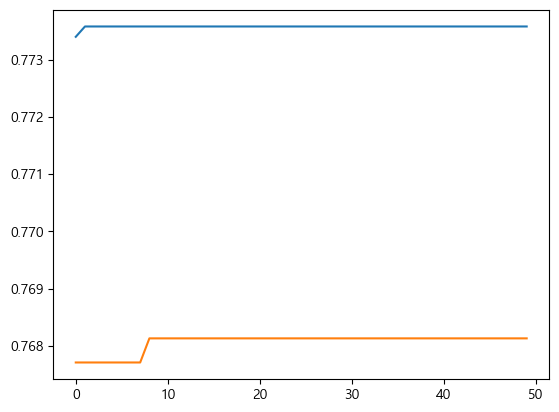

In [41]:
plt.plot(train)
plt.plot(test)

In [42]:
test.index(max(test))

8

In [43]:
lrbest = LogisticRegression()
lrbest.fit(train_scaled , train_target)
lrbest.score(train_scaled , train_target) , lrbest.score(test_scaled , test_target)

(0.7734007950849295, 0.7677065767284992)

## train test가 가장 가까운 곳은 test[0]쪽, 규제가 없을 때 , 점수는 0.83 , 0.83점 정도이다.

In [44]:
from sklearn.linear_model import SGDClassifier
# log_loss : 로지스틱 손실 함수
sc = SGDClassifier(loss = 'log_loss' , max_iter = 1000, tol = None , random_state = 20)
sc.fit(train_scaled , train_target)
print(sc.score(train_scaled , train_target))
print(sc.score(test_scaled , test_target))

0.7392482833393567
0.7322934232715008


In [45]:
sc.partial_fit(train_scaled , train_target)
print(sc.score(train_scaled , train_target))
print(sc.score(test_scaled , test_target))

0.7390675822190098
0.7318718381112985


## 경사하강법을 해봐도 0.83 , 0.83에 미치지 못한다.

# Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 20)

In [47]:
params = {
    'max_depth' : [8,16,24 , 32],
    'min_samples_leaf' : [1,6,12 , 24],
    'min_samples_split' : [2,8,16 , 24]
}

In [48]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(dt , params , n_jobs = -1)
gs.fit(train_input , train_target)
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 16, 'min_samples_leaf': 24, 'min_samples_split': 2}
0.8030386934369644


In [49]:
dtbest = DecisionTreeClassifier(max_depth = 8 , min_samples_split = 8 , random_state = 20) 
dtbest.fit(train_input , train_target)
print(dtbest.score(train_input , train_target))
print(dtbest.score(test_input , test_target))

0.8346584748825443
0.8043844856661045


## DecisionTree는 최대 깊이 24일 때 , 0.98 , 0.88의 점수이다

# Voting

In [50]:
from sklearn.ensemble import VotingClassifier
rfbest = RandomForestClassifier(max_depth = 16 , random_state = 20)
knnbest = KNeighborsClassifier(n_neighbors = 9)
lrbest = LogisticRegression(C = 21)
dtbest = DecisionTreeClassifier(max_depth = 8 , min_samples_split = 8 , random_state = 20) 
#소프트 보팅

vo = VotingClassifier(estimators = [('rf' , rfbest) , ('LR' , lrbest),('Knn' , knnbest) , ('dt' , dtbest)] , voting = 'soft')

#학습

vo.fit(train_input , train_target)

#예측

pred = vo.predict(test_input)

#정확도

accuracy = accuracy_score(test_target , pred)

print('voting 분류기 정확도 : ' , accuracy)

name = [vo.__class__.__name__]
acc = [accuracy]
models = [rfbest , knnbest , lrbest , dtbest]
for i in models:
    i.fit(train_scaled , train_target)
    pred1 = i.predict(test_scaled)

    model_name = i.__class__.__name__
    accuracy1 = accuracy_score(test_target , pred1)
    name.append(model_name)
    acc.append(accuracy1)
    print(f'{model_name} 정확도 : {accuracy1}')

voting 분류기 정확도 :  0.8064924114671164
RandomForestClassifier 정확도 : 0.8145025295109612
KNeighborsClassifier 정확도 : 0.8090219224283305
LogisticRegression 정확도 : 0.7677065767284992
DecisionTreeClassifier 정확도 : 0.8039629005059022


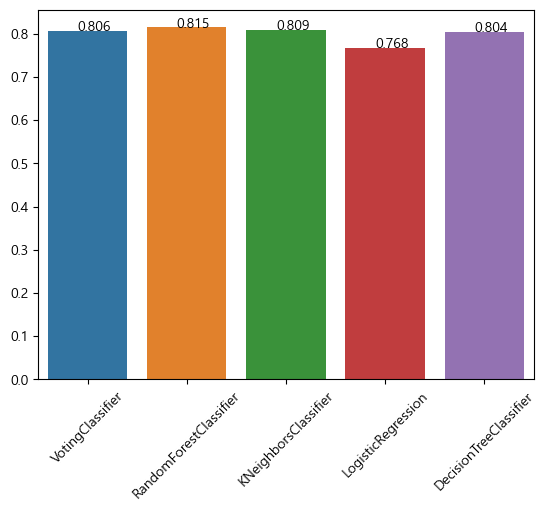

In [51]:
sns.barplot(x = name , y = acc)
plt.xticks(rotation = 45)

for i in range(5):
    plt.text(i-0.1 , acc[i] , round(acc[i],3))

- RandomForest가 정확도가 가장 높다. ( voting 포함 )

# 정확도가 가장 높은 RandomForest로 NA값 대체하기

In [84]:
true_target = car[car['engine'].isna()]

In [85]:
car['seats'].mean()

5.41671936259011

In [86]:
#여기서 seat의 결측값을 5로 채운 이유는 , 결측값을 제외한 seat의 평균이 5.4였기 때문.
true_target['seats'] = 5

In [87]:
true_target

,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
13,13,Maruti Swift 1.3 VXi,2007,200000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,5
31,31,Fiat Palio 1.2 ELX,2003,70000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,5
78,78,Tata Indica DLS,2003,50000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,5
87,87,Maruti Swift VDI BSIV W ABS,2015,475000,78000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,5
119,119,Maruti Swift VDI BSIV,2010,300000,120000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7846,7846,Toyota Qualis Fleet A3,2000,200000,100000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,5
7996,7996,Hyundai Santro LS zipPlus,2000,140000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,5
8009,8009,Hyundai Santro Xing XS eRLX Euro III,2006,145000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,5
8068,8068,Ford Figo Aspire Facelift,2017,580000,165000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,5


In [88]:
#engine이 결측값인 행들을 모델에 집어넣기 위해 인덱싱
true_input = true_target[['selling_price','km_driven','seats']].to_numpy()

In [89]:
true_input

array([[ 200000,   80000,       5],
       [  70000,   50000,       5],
       [  50000,   70000,       5],
       [ 475000,   78000,       5],
       [ 300000,  120000,       5],
       [2150000,   27000,       5],
       [ 235000,  120000,       5],
       [  40000,   90000,       5],
       [ 130000,  120000,       5],
       [  75000,  110000,       5],
       [ 215000,   70000,       5],
       [ 300000,   10000,       5],
       [  85000,   60000,       5],
       [ 265000,  162000,       5],
       [ 330000,  110000,       5],
       [ 160000,   50000,       5],
       [ 229999,   50000,       5],
       [ 204999,   97500,       5],
       [ 204999,   97500,       5],
       [  72000,  110000,       5],
       [ 300000,  120000,       5],
       [ 140000,   65000,       5],
       [ 250000,   80000,       5],
       [ 170000,   55113,       5],
       [  50000,   80000,       5],
       [  80000,  110000,       5],
       [ 400000,   60000,       5],
       [  50000,   60000,   

In [90]:
#표준화해서 모델을 생성했으므로 표준화작업
true_input = ss.transform(true_input)

In [91]:
#결과값
rfbest.predict(true_input)

array([1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0], dtype=int64)

In [92]:
#결과값 채우기
true_target['size'] = rfbest.predict(true_input)

In [93]:
#car가 16열인 이유는 , 앞의 unnamed 때문
car.shape , true_target.shape

((8128, 14), (221, 15))

In [94]:
#앞의 unnamed를 지운 열과 합치고 , unnamed를 기준으로 오름차순(원래 있던 자리에 놓기 위함)
result = pd.concat([car.iloc[:,1:] , true_target]).sort_values('Unnamed: 0')

In [95]:
#unnamed가 또 있는 이유는 , 위에서 reset_index를 했기 때문
result.index = result['Unnamed: 0']

In [96]:
result = result.iloc[:,1:]

In [97]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8349 entries, 13.0 to nan
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           8349 non-null   int64  
 1   selling_price  8349 non-null   int64  
 2   km_driven      8349 non-null   int64  
 3   fuel           8349 non-null   object 
 4   seller_type    8349 non-null   object 
 5   transmission   8349 non-null   object 
 6   owner          8349 non-null   object 
 7   mileage        7907 non-null   object 
 8   engine         7907 non-null   object 
 9   max_power      7919 non-null   object 
 10  torque         7906 non-null   object 
 11  seats          8128 non-null   float64
 12  Unnamed: 0     221 non-null    float64
 13  size           221 non-null    float64
dtypes: float64(3), int64(3), object(8)
memory usage: 978.4+ KB


- size에 NA값이 사라졌다!